# Milestone 3
This notebook should be connected with milestone 2 at one point, but easier to work with two different notebooks.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties

### Question 1 - How has the crops and livestock production changed since the 1960s?
To get a general picture of how production has changed we start by looking at everything at a world-level.

This question will serve as an intro to the whole project and look at the big trends in the world, with focus on products more than areas. We will mainly study total development of production (without normalizing for population), as this is how the production actually has developed and how the scale has changed during the 50 years.
We will follow these steps:

- Get an overview of development by analyzing at world-level.
- Look if any special products have increased/decreased in popularity.
- Find statistical indicators showing the differences now and in 1960.
- Look for certain countries and areas that stand out.

In [131]:
# Load data
data_path = 'data/pickles/'
meat_cont = pd.read_pickle(data_path + 'meat_categorized.pkl')
crops_cont = pd.read_pickle(data_path + 'crops_continents.pkl')
pop_cont = pd.read_pickle(data_path + 'pop_continents.pkl')

In [132]:
from imp import reload
import scripts.visualization
reload(scripts.visualization)
from scripts.visualization import *

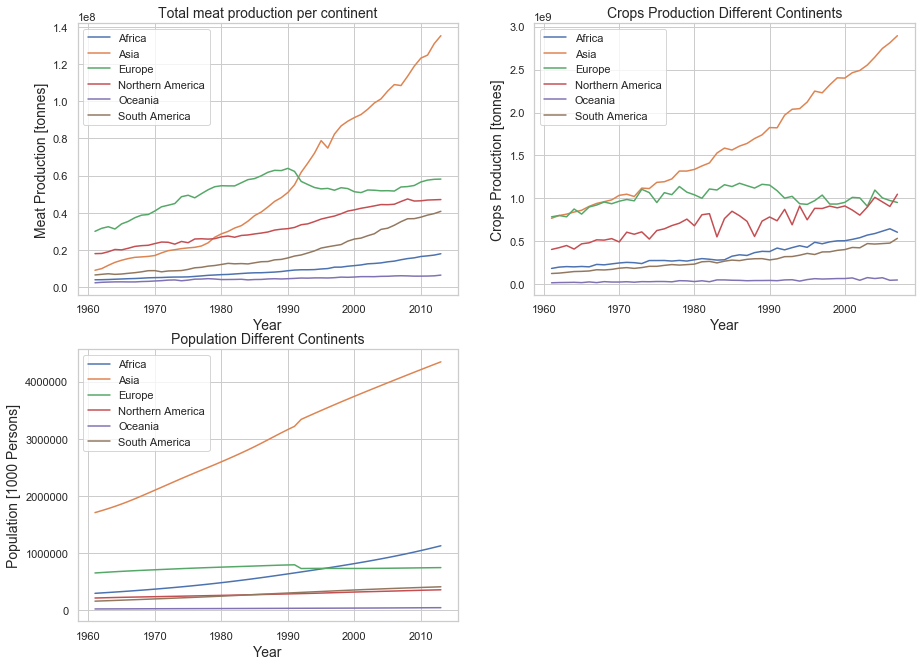

In [133]:
fig = plt.figure(figsize = (15, 11))
meat_total = meat_cont[meat_cont['Item'] == 'Meat, Total']

ax1 = plt.subplot(2,2,1)
plot_compare_areas(meat_total, 
                   y = 'Value', y_label = 'Meat Production [tonnes]',
                   title='Total meat production per continent',
                   subplot = True, ax = ax1)

ax2 = plt.subplot(2,2,2)
plot_compare_areas(crops_cont.groupby(['Area', 'Year']).sum().reset_index(), 
                    y = 'Value', y_label = 'Crops Production [tonnes]',
                    title='Crops Production Different Continents',
                    subplot = True, ax = ax2)

ax3 = plt.subplot(2,2,3)
plot_compare_areas(pop_cont, 
                    y = 'Value', y_label = 'Population [1000 Persons]',
                    title='Population Different Continents',
                    subplot = True, ax = ax3)

In [134]:
# Comparing areawise total production of meat and crops in raw numbers.
meat_1961 = meat_cont[meat_cont['Year'] == 1961]
meat_2007 = meat_cont[meat_cont['Year'] == 2007]

comparison_m = pd.DataFrame({'Area':meat_1961.Area.unique(), 
                          '1961 total [tonnes]':meat_1961[meat_1961['Item'] == 'Meat, Total'].Value.values, 
                          '2007 total [tonnes]':meat_2007[meat_2007['Item'] == 'Meat, Total'].Value.values})
comparison_m['% Increase'] = round(comparison_m['2007 total [tonnes]']/comparison_m['1961 total [tonnes]']*100-100,2)
print(comparison_m.sort_values(by = 'Area'))

comparison_c = crops_cont[crops_cont['Year'] == 1961].groupby(['Area']).Value.sum().reset_index()

comparison_c['2007 total [tonnes]'] = np.asarray(crops_cont[crops_cont['Year'] == 2007].groupby(['Area']).sum().Value)
comparison_c.rename(columns = {'Value':'1961 total [tonnes]'}, inplace = True)
comparison_c['% Increase'] = round(comparison_c['2007 total [tonnes]']/comparison_c['1961 total [tonnes]']*100-100,2)

print(comparison_c.sort_values(by = 'Area'))

               Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
0            Africa            3910553.0           14699140.0      275.88
1              Asia            9046039.0          108466131.0     1099.05
2            Europe           30004080.0           53861619.0       79.51
3  Northern America           17992024.0           46055112.0      155.98
4           Oceania            2298457.0            6083622.0      164.68
5     South America            6517115.0           35185524.0      439.89
               Area  1961 total [tonnes]  2007 total [tonnes]  % Increase
0            Africa          185133809.0         6.063324e+08      227.51
1              Asia          768769932.0         2.894075e+09      276.46
2            Europe          785834413.0         9.528634e+08       21.25
3  Northern America          405989866.0         1.048896e+09      158.36
4           Oceania           18037162.0         5.058865e+07      180.47
5     South America          126125547

Text(0.5, 1.0, 'Mean yearly (%) increase of different crops')

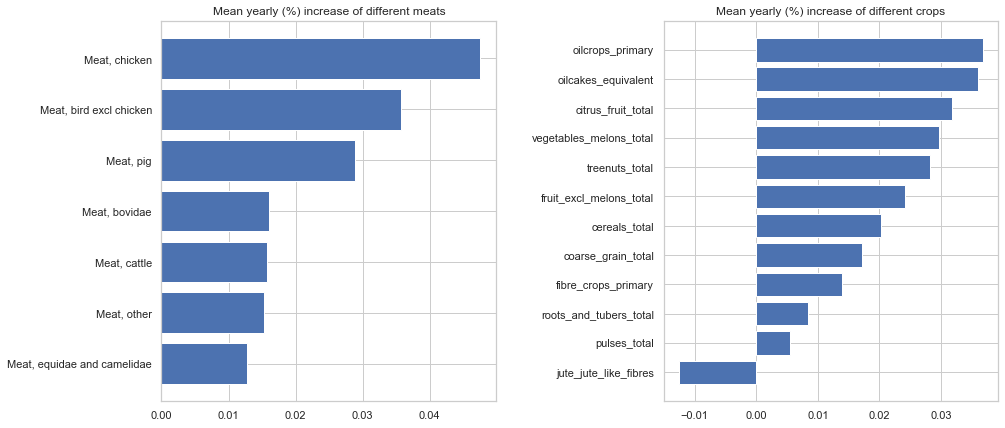

In [135]:
# Comparison of the yearly increases of different meat and crop production. 

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(15,7)
fig.subplots_adjust(wspace = 0.5)

# Create dataframes with mean yearly change in production of different products
mean_mproduct_growth = {}
for meat_product in meat_cont.Item.unique():
    if (meat_product != 'Meat, Total'):
        mean_mproduct_growth.update({meat_product: (meat_cont[meat_cont['Item'] == meat_product].groupby('Year').sum().diff() 
                                                    / meat_cont[meat_cont['Item'] == meat_product].groupby('Year').sum()).Value.mean()})

mean_mproduct_growth = pd.DataFrame(mean_mproduct_growth.values(), mean_mproduct_growth.keys(), columns = ['Mean growth'])
mean_mproduct_growth.sort_values(by='Mean growth', inplace =True)


mean_cproduct_growth = {}
for crop in crops_cont.Item.unique():
    mean_cproduct_growth.update({crop : (crops_cont[crops_cont['Item'] == crop].groupby(['Year']).sum().diff()/\
                                 crops_cont[crops_cont['Item'] == crop].groupby(['Year']).sum()).Value.mean()})

mean_cproduct_growth = pd.DataFrame(mean_cproduct_growth.values(), mean_cproduct_growth.keys(), columns = ['Mean growth'])
mean_cproduct_growth.sort_values(by='Mean growth', inplace =True)


ax[0].barh(mean_mproduct_growth.index, mean_mproduct_growth['Mean growth'])
ax[0].set_title("Mean yearly (%) increase of different meats")

ax[1].barh(mean_cproduct_growth.index, mean_cproduct_growth['Mean growth'])
ax[1].set_title("Mean yearly (%) increase of different crops")

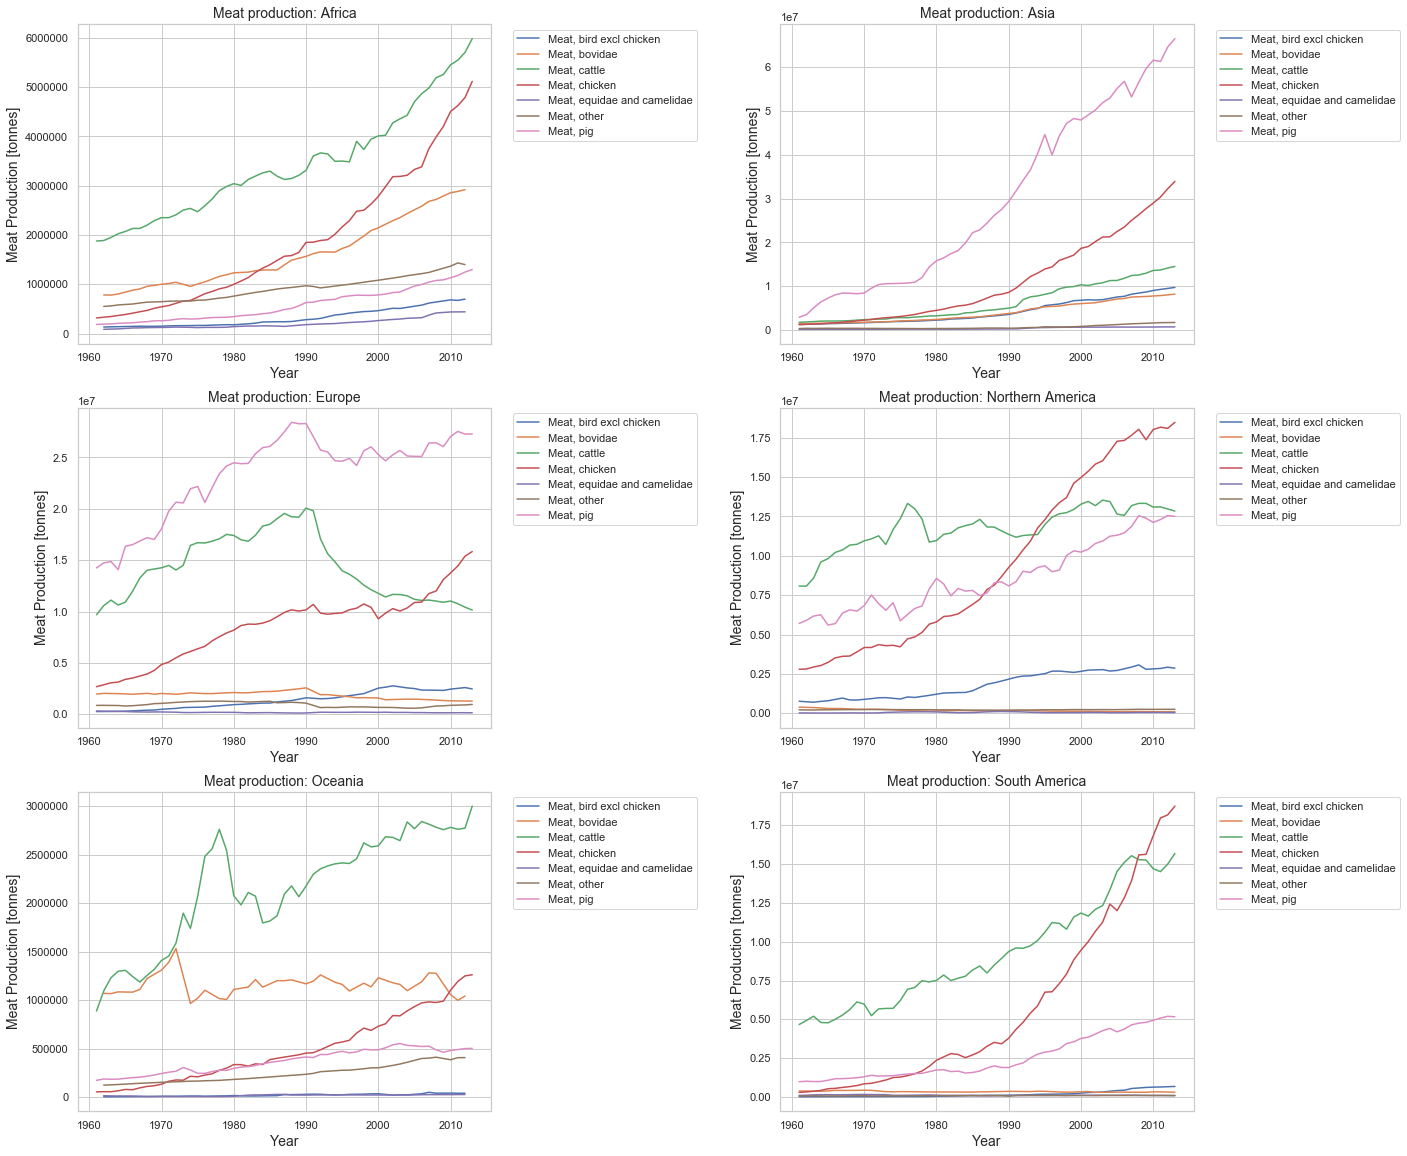

In [136]:
# WIP how to get colors to be consistent?
no_total = meat_cont.drop(meat_cont[meat_cont['Item'] == 'Meat, Total'].index)


plt.figure(figsize=(20,20)).subplots_adjust(wspace=0.7)
i = 0

for area in meat_cont.Area.unique():
    i+=1
    plot_compare_areas(no_total[no_total['Area'] == area], grouping = 'Item',
                  y = 'Value', y_label = 'Meat Production [tonnes]', title = 'Meat production: '+area,
                    subplot = True, ax = plt.subplot(3, 2, i), outside = True)

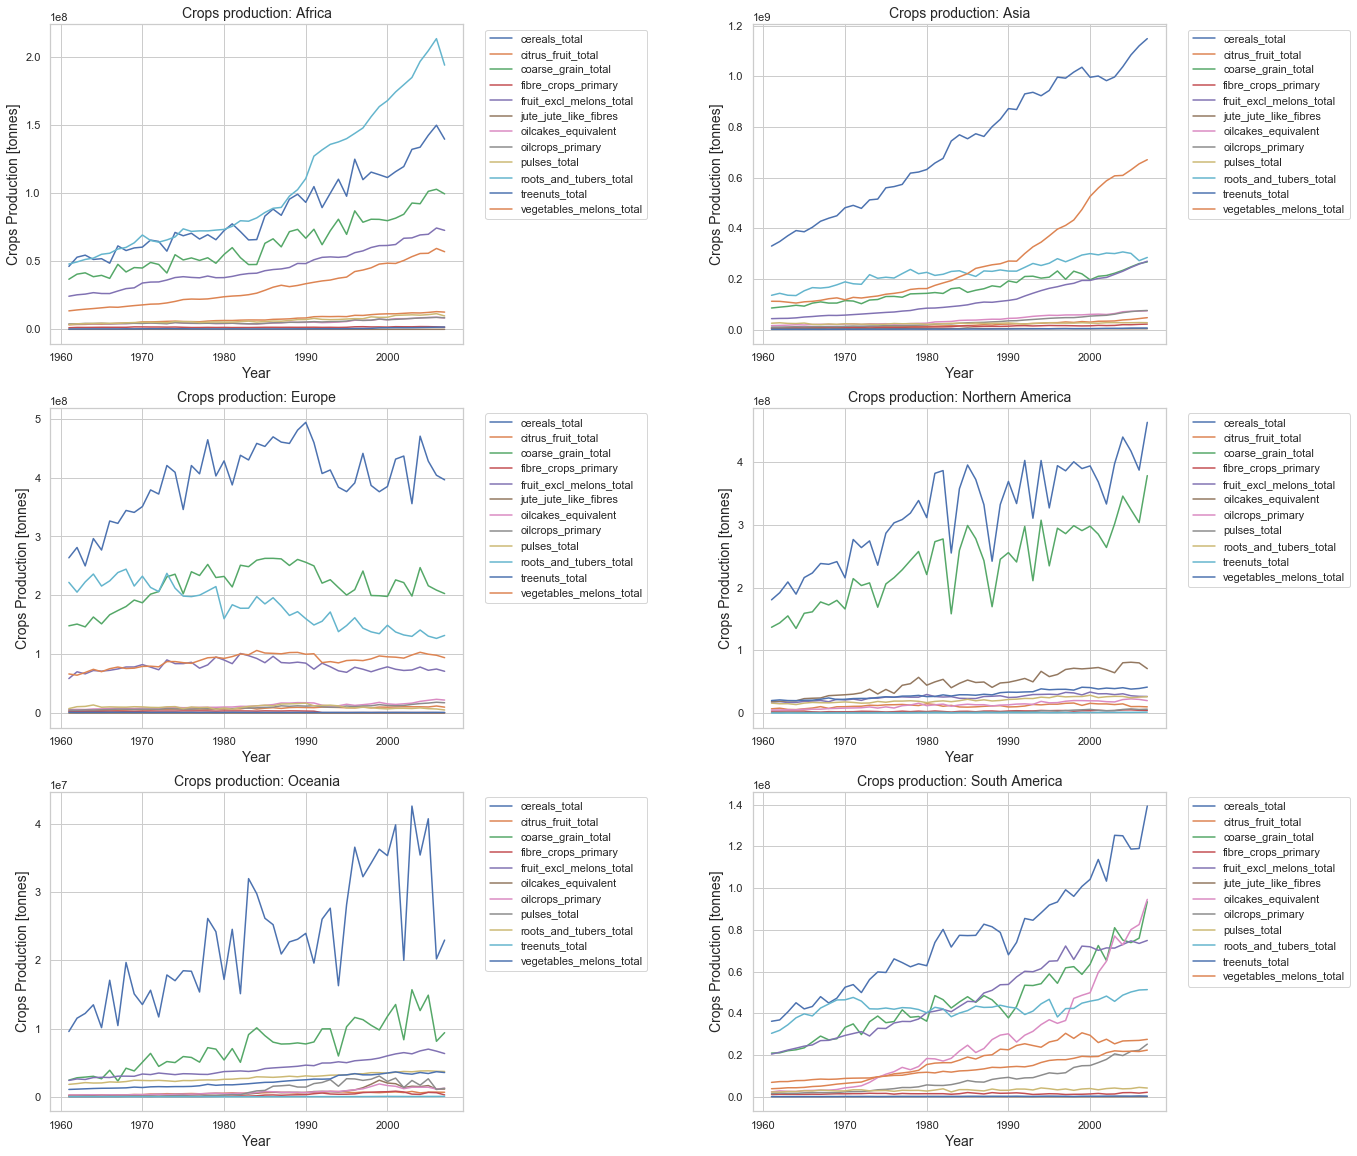

In [137]:
fig = plt.figure(figsize = (20, 20)).subplots_adjust(wspace=0.7)
i = 0

for area in crops_cont.Area.unique():
    i+=1
    plot_compare_areas(crops_cont[crops_cont['Area'] == area], grouping = 'Item',
              y = 'Value', y_label = 'Crops Production [tonnes]', title = 'Crops production: '+area,
                subplot = True, ax = plt.subplot(3, 2, i), outside = True)

We can see that that most products have experienced a positive average growth yearly. Only production of other camelids and jute like fibres has decreased.

### Question 2 - Is there a connection between the development of livestock primary production and crop production?

The purpose of this question is to see if there are any trends in our data, and to answer this we will study both total and normalized data. We will also have to look at

- Are we producing more food per person?
- Has the porportions of meat vs. crops changed in our diet?
- Can we see differences between each continent?

In [9]:
# Calculating year on year growth of meat and crop production
mean_meat_prodgrow = (meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum().diff()/\
    meat_cont[meat_cont['Item'] == 'Meat, Total'].groupby('Year').sum()).Value.mean()*100

mean_crop_prodgrow = (crops_cont[crops_cont['Item'] == 'cereals_total'].groupby('Year').sum().diff()/\
    crops_cont[crops_cont['Item'] == 'cereals_total'].groupby('Year').sum()).Value.mean()*100

mean_pop_growth = (pop_cont.groupby('Year').sum().diff()/pop_cont.groupby('Year').sum()).Value.mean()*100

print("Meat production has grown on average by %2.2f%% yearly, while crops production has grown by %2.2f%%." \
      % (mean_meat_prodgrow, mean_crop_prodgrow))
print("Meanwhile the population has grown on average by %2.2f %% yearly." \
      % (mean_pop_growth))

Meat production has grown on average by 2.79% yearly, while crops production has grown by 2.03%.
Meanwhile the population has grown on average by 1.61 % yearly.


In [10]:
comparison_m.sort_values(by = 'Area', inplace = True)
comparison_c.sort_values(by = 'Area', inplace = True)

pop_cont1961 = pop_cont[pop_cont['Year'] == 1961].drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()
pop_cont2007 = pop_cont[pop_cont['Year'] == 2007].drop('Area Code', axis = 1).sort_values(by = 'Area').reset_index()

product_pers = pd.DataFrame({'Area':comparison_m.Area,
                             'Meat per person 1961 (kg)':comparison_m['1961 total [tonnes]'].values/pop_cont1961.Value,
                             'Meat per person 2007 (kg)':comparison_m['2007 total [tonnes]'].values/pop_cont2007.Value,
                             'Crops per person 1961 (kg)':comparison_c['1961 total [tonnes]'].values/pop_cont1961.Value,
                             'Crops per person 2007 (kg)':comparison_c['2007 total [tonnes]'].values/pop_cont2007.Value})
product_pers['% Increase meat'] = round(product_pers['Meat per person 2007 (kg)']/product_pers['Meat per person 1961 (kg)']*100-100,2)
product_pers['% Increase crops'] = round(product_pers['Crops per person 2007 (kg)']/product_pers['Crops per person 1961 (kg)']*100-100,2)

product_pers

,Area,Meat per person 1961 (kg),Meat per person 2007 (kg),Crops per person 1961 (kg),Crops per person 2007 (kg),% Increase meat,% Increase crops
0,Africa,12.870233,15.141945,637.920628,629.614385,17.65,-1.30
1,Northern America,5.335818,26.635093,451.125715,710.862655,399.18,57.58
2,South America,46.468266,73.485365,1215.135412,1301.835252,58.14,7.13
3,Asia,86.406400,136.403041,1952.933606,3143.525706,57.86,60.96
4,Europe,140.866689,183.577888,1102.921385,1449.491258,30.32,31.42
5,Oceania,42.534129,94.212414,825.775312,1407.529798,121.50,70.45


### Question 3 - How are the differences in production quantities between the different continents?

The purpose of this question is to study the difference in production at a continent-level. For example, it can be interesting to see the difference between developed continents, like Europe and North-America, and continents like Africa and Asia.

- Study food production in general, and with a crops vs. meat analysis.
- What can be said about the normalized production?
- Can we say if any continents are producing more than it needs?
- Try to find data on how much food a person needs per year.
    - This is pretty hard because of energy/tonne

### Question 4 - How has the development in agriculture affected emission of greenhouse gasses?

This question is about the consequences of what we have studied in the previous questions.

- Can we find evidence that higher meat consumption leads to higher emissions?
- Is it better for the environment to eat crops rather than livestock?
- Are there any particular meat or crop that affect the CO2 emissions more/less than the average?

In [11]:
# Load data from total agricultural emissions dataset
emission_data = pd.read_pickle(data_path + 'agriculture_emissions_continents.pkl')
emission_data.head(5)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1961,1961,gigagrams,233438.4999,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1962,1962,gigagrams,237662.8733,A,"Aggregate, may include official, semi-official...",NaN
2,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1963,1963,gigagrams,241883.7194,A,"Aggregate, may include official, semi-official...",NaN
3,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1964,1964,gigagrams,248689.6523,A,"Aggregate, may include official, semi-official...",NaN
4,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1965,1965,gigagrams,255912.4287,A,"Aggregate, may include official, semi-official...",NaN


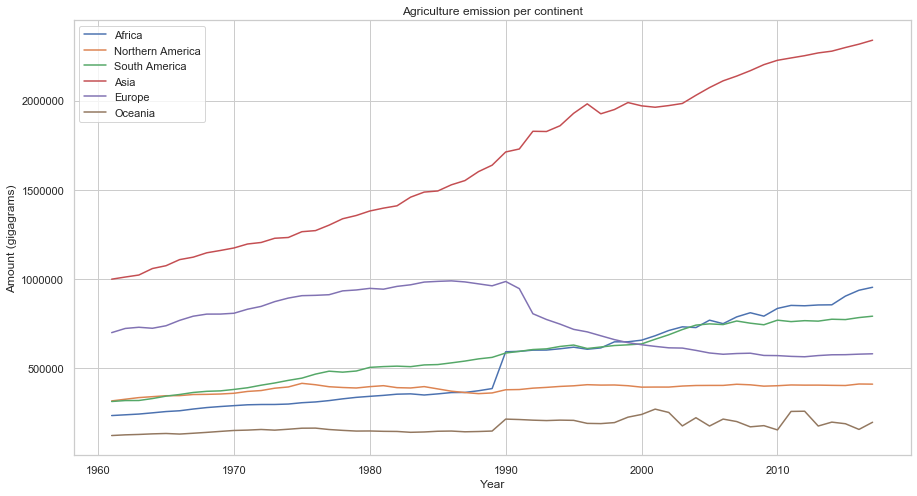

In [12]:
# Plot total CO2 emission data per continent 
fig = plt.figure(figsize = (15,8))

for area in emission_data.Area.unique():
    plt.plot(emission_data[emission_data['Area'] == area].Year.values, 
             emission_data[emission_data['Area'] == area].Value.values)
    
plt.legend(emission_data.Area.unique())
plt.title('Agriculture emission per continent')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')
plt.show()

From the plot above it is possible to see that the CO2 emissions from agriculture has increased in every continent since the 1960s, apart from Europe. Europe has had a large decrease in agriculture emissions. How is this connected to its livestock/crops production?

#### Study regarding Europe's emissions

<Figure size 1080x576 with 0 Axes>

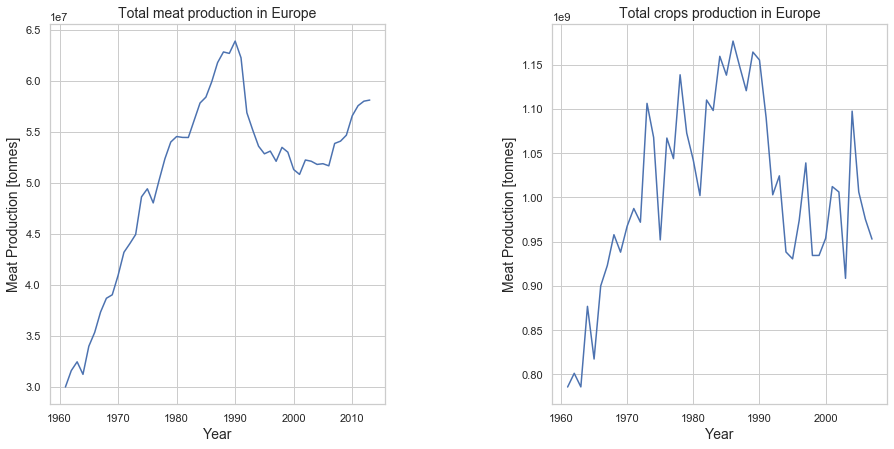

In [13]:
crops_total = crops_cont.groupby(['Area', 'Year']).agg({'Value':'sum'}).reset_index()
meat_total = meat_cont[meat_cont['Item'] == 'Meat, Total']

fig = plt.figure(figsize = (15,8))
plot_crop_livestock(meat_total[meat_total.Area.str.contains('Europe')], crops_total[crops_total.Area.str.contains('Europe')], 
                    y = 'Value', y_label = 'Meat Production [tonnes]',
                    title1='Total meat production in Europe', title2='Total crops production in Europe',
                    subplot = False)

We choose to compare the emissions and the crops/meat production in 1990 vs. 2005. The emissions were at its highest in 1990 and they are a lot lower in 2005. Can we find a connection between less meat production leading to lower emissions? 

In [72]:
# Function to calculate change in crops & meat production and CO2 emissions between two years for a certain area
def calculate_year_change(year1, year2, area):
    crops_prod_y1 = crops_total[crops_total.Year == year1][crops_total.Area.str.contains(area)].Value.array[0]
    meat_prod_y1 = meat_total[meat_total.Year == year1][meat_total.Area.str.contains(area)].Value.array[0]
    emissions_y1 = emission_data[emission_data.Year == year1][emission_data.Area.str.contains(area)].Value.array[0]

    crops_prod_y2 = crops_total[crops_total.Year == year2][crops_total.Area.str.contains(area)].Value.array[0]
    meat_prod_y2 = meat_total[meat_total.Year == year2][meat_total.Area.str.contains(area)].Value.array[0]
    emissions_y2 = emission_data[emission_data.Year == year2][emission_data.Area.str.contains(area)].Value.array[0]
    
    print(area, ':', year1, 'vs.', year2)

    meat_change = meat_prod_y2 / meat_prod_y1
    crops_change = crops_prod_y2 / crops_prod_y1
    emissions_change = emissions_y2 / emissions_y1

    print('\nThe meat production in 1990 is approximatly %3.0f%% of what it was in 1990.' % (meat_change*100))
    print('The crops production in 1990 is approximatly %3.0f%% of what it was in 1990.' % (crops_change*100))
    print('The agricultural emissions in 1990 are approximatly %3.0f%% of what they were in 1990.' % (emissions_change*100))
    
calculate_year_change(1980, 2005, 'Europe')

Europe : 1980 vs. 2005

The meat production in 1990 is approximatly  95% of what it was in 1990.
The crops production in 1990 is approximatly  97% of what it was in 1990.
The agricultural emissions in 1990 are approximatly  62% of what they were in 1990.


We can see here that we aren't producing that much less food in 2005 compared to 1990 but we still get a huge decrease in emissions. There is only a 13% decrease in crops production and a 19% decrease in meat production and this change results in 41% decrease in emissions. This information is not detailed enough to be able to say weather the decrease in meat production has lead to the decrease in emissions. 

#### Correlation between emissions and total crops production / total meat production

We choose to study the correlation between meat & crops production and the emissions to see if there is a strong connection. Since the crops dataset only has data up to 2007 we will only study the data up until 2007.

In [85]:
meat_relevant = meat_total[meat_total.Year < 2008]
emissions_relevant = emission_data[emission_data.Year < 2008]

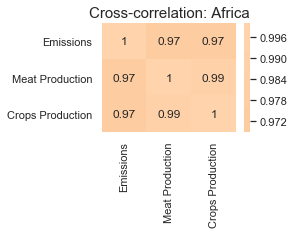

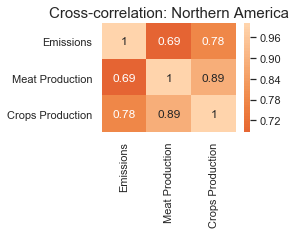

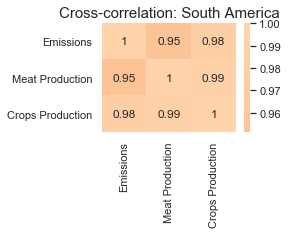

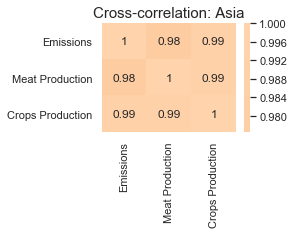

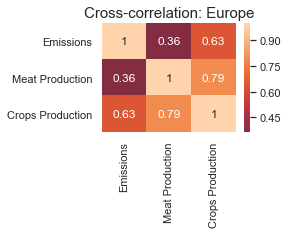

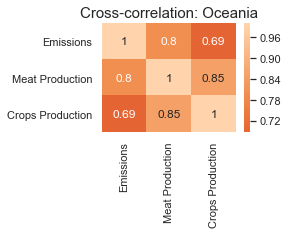

In [77]:
def check_correlation(meat_data, crops_data, emission_data):
    for area in meat_data.Area.unique():
        meat = meat_data[meat_data.Area.str.contains(area)].reset_index()
        crops = crops_data[crops_data.Area.str.contains(area)].reset_index()
        emissions = emission_data[emission_data.Area.str.contains(area)].reset_index()

        corr_data = pd.DataFrame(data = {'Emissions': emissions.Value, 'Meat Production': meat.Value, 'Crops Production': crops.Value}) 
        corr = corr_data.corr()
        fig = plt.figure(figsize = (3, 2))

        ax = sns.heatmap(corr, center = 0, annot = True)
        plt.yticks(rotation= 0)
        plt.xticks(rotation= 90)
        plt.title('Cross-correlation: ' + area, fontsize = 15)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.show()
        
check_correlation(meat_relevant, crops_total, emissions_relevant)

As we can see from the first row in each of the correlation matrices, there is no specific pattern regarding the correlation between meat production and emissions or crops production and emissions.

#### Study on different crops/meat categories

In [73]:
world_categorized_emissions = pd.read_pickle(data_path + 'world_categorized_emissions.pkl')
world_categorized_production = pd.read_pickle(data_path + 'world_categorized_production.pkl')

world_categorized_emissions.Item.unique()

array(['Cereals excluding rice', 'Rice, paddy', 'Meat, cattle',
       'Meat, goat', 'Meat, buffalo', 'Meat, sheep', 'Meat, chicken',
       'Meat, pig'], dtype=object)

As we can see, there are only two types of crop categories. We are therefore missing emission data for other categories. The same goes for meat, as we for example are missing emissions for camel. We will have to work with the little information that we have for now.

We choose to plot the emissions per product category. The emissions are given as amount of gigagrams emitted per tonne produced.

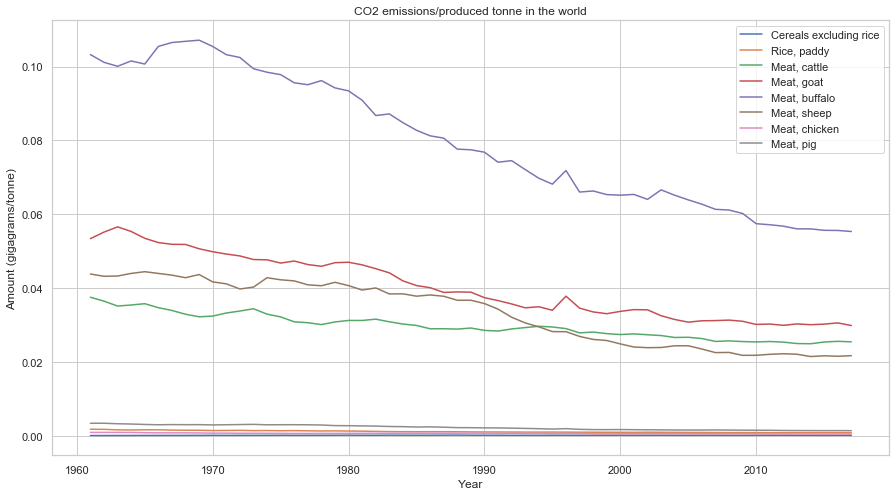

In [74]:
# Plot how much each type of meat emits for every tonne produced
fig = plt.figure(figsize = (15,8))

for item in world_categorized_emissions.Item.unique():
    plt.plot(world_categorized_emissions[world_categorized_emissions['Item'] == item].Year.values, 
             world_categorized_emissions[world_categorized_emissions['Item'] == item].Value.values
             /(world_categorized_production[world_categorized_production['Item'] == item].Value.values))
    
plt.legend(world_categorized_emissions.Item.unique())

plt.title('CO2 emissions/produced tonne in the world')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams/tonne)')
plt.show()

As we can see we are producing meat in a more sustainable way nowadays compared to 1960, since we are emitting less CO2 today per tonne meat produced compared to 1960. The same goes for the crops production cor cereals and rice. We can also see that the amount of emissions per tonne cereal/rice crops produced is a lot lower than the emissions for cattle, goat, buffalo and sheep. Pig and chicken however have low emissions.

#### Correlation between emissions and specific crops/meat categories

Since we are able to see such a huge difference in emissions between buffalo, cattle, sheep and goat in comparison towards the other categories, we will study the correlation one last time between emission and these distinct categories to see if there is anything interesting to be found.  We will also check four of the most produced crops categories: cereals_total, coarse_grain_total, roots_and_tubers_total, fruit_excl_melons_total.

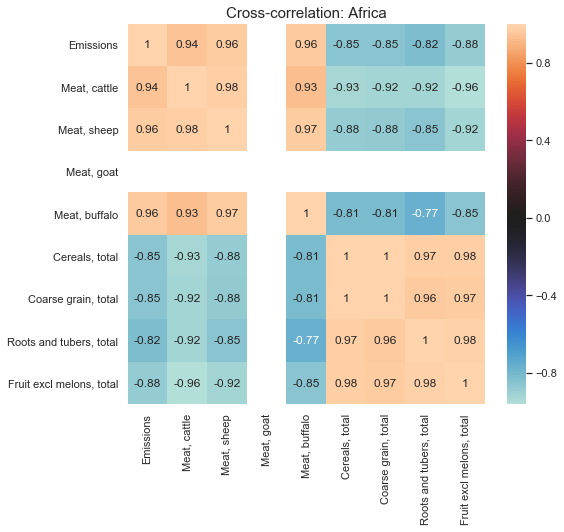

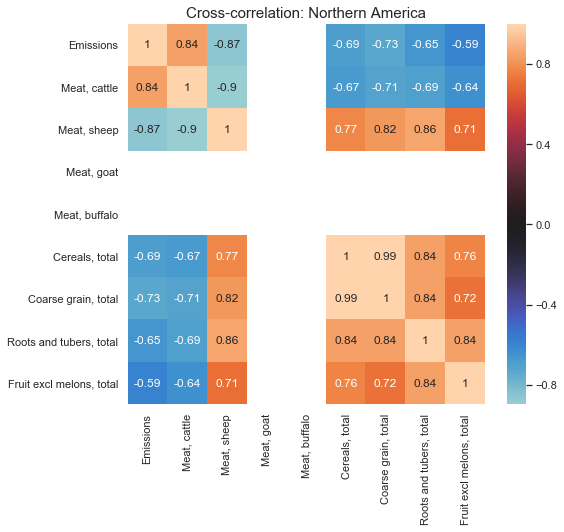

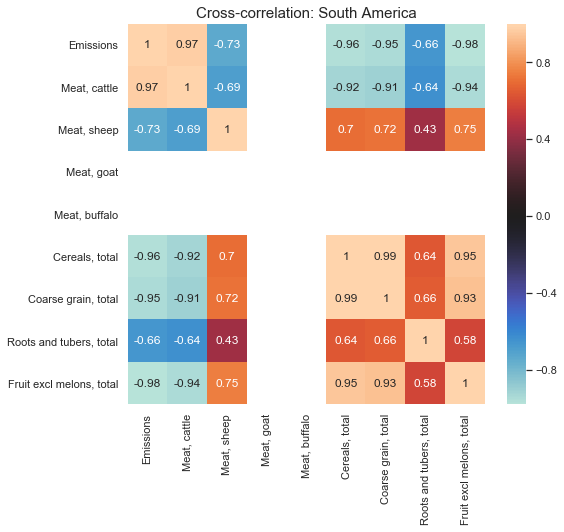

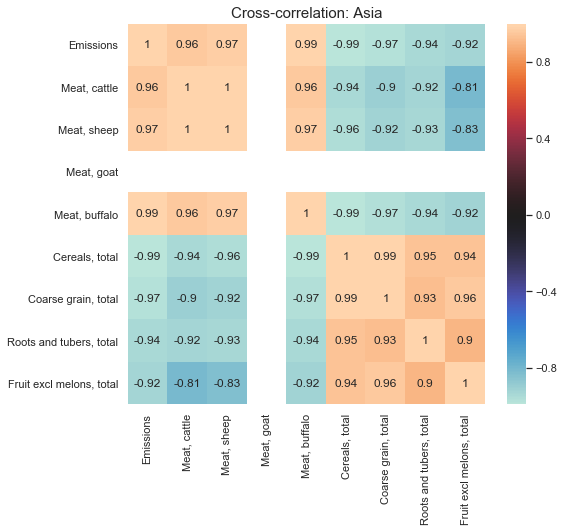

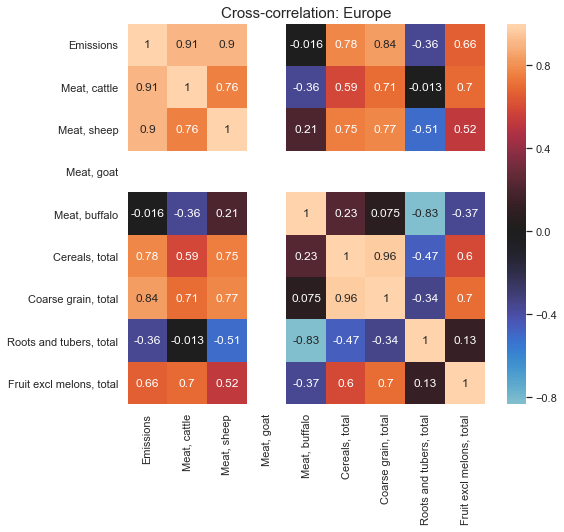

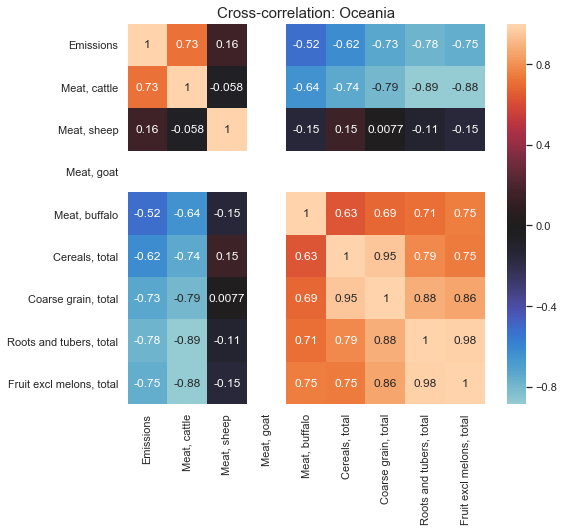

In [98]:
meat_cat = ['Meat, cattle', 'Meat, buffalo', 'Meat, sheep', 'Meat,goat']
crops_cat = ['cereals_total', 'coarse_grain_total', 'roots_and_tubers_total', 'fruit_excl_melons_total']

meat_relevant = meat_cont[meat_cont.Item.isin(meat_cat)][meat_cont.Year < 2008]
crops_relevant = crops_cont[crops_cont.Item.isin(crops_cat)]

# I know that this is repeating the code from earlier
def check_correlation_categories(meat_relevant, crops_relevant, emissions_relevant):
    for area in meat_relevant.Area.unique():
            meat = meat_relevant[meat_relevant.Area.str.contains(area)].reset_index()
            crops = crops_relevant[crops_relevant.Area.str.contains(area)].reset_index()
            emissions = emissions_relevant[emissions_relevant.Area.str.contains(area)].reset_index()

            corr_data = pd.DataFrame(data = {'Emissions': emissions.Value, 
                                             'Meat, cattle': meat[meat.Item.str.contains('Meat, cattle')].reset_index().Value,
                                             'Meat, sheep': meat[meat.Item.str.contains('Meat, sheep')].reset_index().Value,
                                             'Meat, goat': meat[meat.Item.str.contains('Meat, goat')].reset_index().Value,
                                             'Meat, buffalo': meat[meat.Item.str.contains('Meat, buffalo')].reset_index().Value,
                                             'Cereals, total': crops[crops.Item.str.contains('cereals_total')].reset_index().Value,
                                             'Coarse grain, total': crops[crops.Item.str.contains('coarse_grain_total')].reset_index().Value,
                                             'Roots and tubers, total': crops[crops.Item.str.contains('roots_and_tubers_total')].reset_index().Value,
                                             'Fruit excl melons, total': crops[crops.Item.str.contains('fruit_excl_melons_total')].reset_index().Value}) 
            corr = corr_data.corr()
            fig = plt.figure(figsize = (8, 7))

            ax = sns.heatmap(corr, center = 0, annot = True)
            plt.yticks(rotation= 0)
            plt.xticks(rotation= 90)
            plt.title('Cross-correlation: ' + area, fontsize = 15)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.show()

check_correlation_categories(meat_relevant, crops_relevant, emissions_relevant)

As we can see here, these four meat categories do in general correlate with the emissions and the crops do not. Europe is an exception as here the crops actually do correlate with the emission.

What does this correlation matrix look like on a world level?

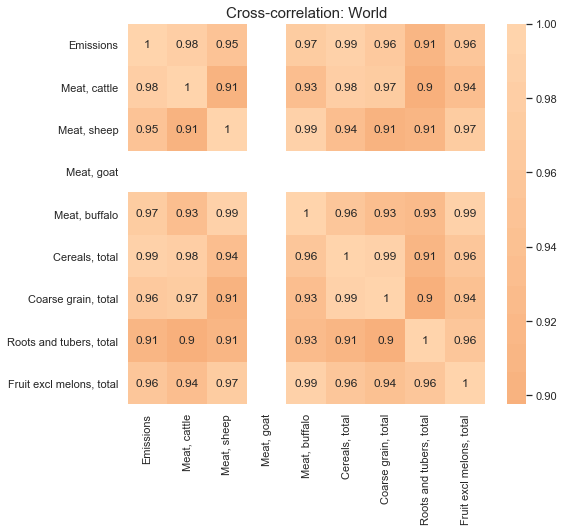

In [99]:
meat_world_relevant = meat_relevant.groupby(['Item','Year']).agg({'Value':'sum'}).reset_index()
meat_world_relevant['Area'] = 'World'
crops_world_relevant = crops_relevant.groupby(['Item','Year']).agg({'Value':'sum'}).reset_index()
crops_world_relevant['Area'] = 'World'
emissions_world_relevant = emissions_relevant.groupby(['Item','Year']).agg({'Value':'sum'}).reset_index()
emissions_world_relevant['Area'] = 'World'

check_correlation_categories(meat_world_relevant, crops_world_relevant, emissions_world_relevant)

It's odd that the correlation matrix above looks so different when looking at world level compared to continent level. 